### Box 6.1 Finding Correlations between Returns of Different Time Frames

In [1]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm
from scipy.stats import pearsonr

In [2]:
df=pd.read_csv('inputDataOHLCDaily_TU_20120511.csv')
# remove HH:MM:SS
df['Date']=pd.to_datetime(df['Date'],  format='%Y%m%d').dt.date
df.set_index('Date', inplace=True)

In [3]:
correlation_table = []
for lookback in [1, 5, 10, 25, 60, 120, 250]:
    for holddays in [1, 5, 10, 25, 60, 120, 250]:
        ret_lag=df.pct_change(periods=lookback)
        ret_fut=df.shift(-holddays).pct_change(periods=holddays)
        if (lookback >= holddays):
            indepSet=range(0, ret_lag.shape[0], holddays)
        else:
            indepSet=range(0, ret_lag.shape[0], lookback)
            
        ret_lag=ret_lag.iloc[indepSet]
        ret_fut=ret_fut.iloc[indepSet]
        goodDates=(ret_lag.notna() & ret_fut.notna()).values
        (cc, pval)=pearsonr(ret_lag[goodDates]['Close'], ret_fut[goodDates]['Close'])
        # print('%4i %4i %7.4f %7.4f' % (lookback, holddays, cc, pval))
        correlation_table.append([lookback, holddays, cc, pval])
correlation_df = pd.DataFrame(correlation_table,
                              columns =['Look-back', 'Holding days', 'Correlation coefficient', 'p-value'])
correlation_df

,Look-back,Holding days,Correlation coefficient,p-value
0,1,1,-0.057622,0.009971
1,1,5,-0.076859,0.000591
2,1,10,-0.027351,0.222620
3,1,25,-0.013904,0.536874
4,1,60,0.032468,0.152855
5,1,120,0.020538,0.373471
6,1,250,0.038339,0.108872
7,5,1,-0.075547,0.000733
8,5,5,-0.127094,0.011052
9,5,10,-0.047113,0.348517


**TABLE 6.1** Correlations between TU Returns of Different Time Frames

In [4]:
correlation_df[
    (correlation_df['Correlation coefficient'] >= 0.2) &
    (correlation_df['p-value'] <= 0.1)]

,Look-back,Holding days,Correlation coefficient,p-value
25,25,60,0.237187,0.037802
27,25,250,0.248179,0.038306
45,250,25,0.271905,0.022784
46,250,60,0.328218,0.082161


### Time Series Strategies

For a certain future, if we find that the correlation coefficient between a past return of a certain look-back and a future return of a certain holding period is high, and the p-value is small, we can proceed to see if a profitable momentum strategy can be found using this set of optimal time periods. Since Table 6.1 shows us that for TU, the 250-25-days pairs of returns have a correlation coefficient of 0.27 with a p-value of 0.02, we will pick this look-back and holding period. We take our cue for a simple time series momentum strategy from a paper by Moskowitz,Yao, and Pedersen: simply buy (sell) the future if it has a positive (negative) 12-month return, and hold the position for 1 month ([Moskowitz, Yao, and Pedersen, 2012](https://www.sciencedirect.com/science/article/pii/S0304405X11002613)). We will modify one detail of the original strategy: Instead of making a trading decision every month, we will make it every day, each day investing only one twenty-fifth of the total capital.

### Example 6.1: TU Momentum Strategy

<Axes: xlabel='June 1, 2004, to May 11, 2012', ylabel='Cumulative Returns'>

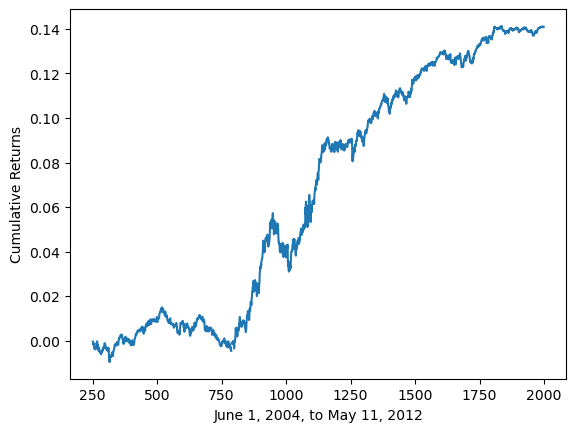

In [5]:
lookback=250
holddays=25

longs=df > df.shift(lookback)
shorts=df < df.shift(lookback)

pos=np.zeros(df.shape)

for h in range(holddays-1):
    long_lag=longs.shift(h).fillna(False)
    short_lag=shorts.shift(h).fillna(False)
    pos[long_lag]=pos[long_lag]+1
    pos[short_lag]=pos[short_lag]-1
    
pos=pd.DataFrame(pos)
# daily P&L of the strategy
pnl=np.sum((pos.shift().values)*(df.pct_change().values), axis=1)
ret=pnl/np.sum(np.abs(pos.shift()), axis=1)
cumret=(np.cumprod(1+ret)-1)
cumret.plot(
    xlabel='June 1, 2004, to May 11, 2012',
    ylabel='Cumulative Returns'
)

**FIGURE 6.2** Equity Curve of TU Momentum Strategy

In [6]:
def calculateMaxDD(cumret):
# =============================================================================
# calculation of maximum drawdown and maximum drawdown duration based on
# cumulative COMPOUNDED returns. cumret must be a compounded cumulative return.
# i is the index of the day with maxDD.
# =============================================================================
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=(1+cumret[t])/(1+highwatermark[t])-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    # drawdown < 0 always
    maxDD, i=np.min(drawdown), np.argmin(drawdown)
    maxDDD=np.max(drawdownduration)
    return maxDD, maxDDD, i

In [7]:
print('APR=%f Sharpe=%f' % (np.prod(1+ret)**(252/len(ret))-1, np.sqrt(252)*np.mean(ret)/np.std(ret)))
from calculateMaxDD import calculateMaxDD
maxDD, maxDDD, i=calculateMaxDD(cumret.fillna(0))
print('Max DD=%f Max DDD in days=%i' % (maxDD, maxDDD))

APR=0.016751 Sharpe=1.089553
Max DD=-0.024847 Max DDD in days=342


From June 1, 2004, to May 11, 2012, the Sharpe ratio is a respectable 1. The annual percentage rate (APR) of 1.7 percent may seem low, but our return is calculated based on the notional value of the contract, which is about \\$200,000. Margin requirement for this contract is only about \\$400. So you can certainly employ a reasonable amount of leverage to boost return, though one must also contend with the maximum drawdown of 2.5 percent. The equity curve also looks quite attractive (see Figure 6.2).